# Label propagation

Goal: determine the number of non-diagnosed / non-tested individuals in the phase 2 population. To extend the knowledge on this unlabelled set from the small labelled subset, we will establish the followin setting:

1. Baseline model > just run the validated transfer-learning-model (validated on phase 2 labelled data) on the unlabelled data
2. Classic approach on label propagation [2]
3. A dual self-supervised learning (SSL) and Semi-supervised learning (Semi-SL) [1] will be implemented.



[1]: Yoon, J., Zhang, Y., Jordon, J., & van der Schaar, M. (2020). Vime: Extending the success of self-and semi-supervised learning to tabular domain. Advances in Neural Information Processing Systems, 33, 11033-11043.
[2]: ZhuЃ, X., & GhahramaniЃн, Z. (2002). Learning from labeled and unlabeled data with label propagation. ProQuest Number: INFORMATION TO ALL USERS.

## Load libraries and data

In [232]:
import os
import numpy as np
import pandas as pd
import importlib
import joblib
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from scipy.sparse import csr_matrix
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *
from auxFuns.transfer_learning import *

In [231]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

import auxFuns.transfer_learning
importlib.reload(auxFuns.transfer_learning)

<module 'auxFuns.transfer_learning' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\transfer_learning.py'>

In [14]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

# Phase 2 data
rsv_phase2_df = pd.read_csv(processed_datasets_path + '/rsv_phase2_all_features.csv',low_memory=False)
rsv_phase2_df = make_it_categorical_v2(rsv_phase2_df, is_phase1 = False)

# Small subset of labelled data of phase 2:
labels_phase2_df = pd.read_csv(raw_datasets_path + '/rsv_test_phase2.csv',low_memory=False)
labels_phase2_df = labels_phase2_df.rename(columns = {'RSV_test_date':'index_date'})

# Compatibility issue detected: merging labelled and unlabelled data is challening due to incompatible date columns
rsv_phase2_df.index_date = pd.to_datetime(rsv_phase2_df.index_date)
labels_phase2_df.index_date = pd.to_datetime(labels_phase2_df.index_date)

rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id', 'index_date'])
# rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id'])
rsv_phase2_labelled_df = rsv_phase2_labelled_df.dropna()

rsv_predictors_phase1_df.shape, rsv_phase2_df.shape, rsv_phase2_labelled_df.shape

((86058, 64), (291938, 63), (2867, 64))

In [10]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

rsv_test_related_features = ['n_tests_that_day', 'previous_test_daydiff', 'multiple_tests']
selected_features_v4 = selected_features_v2.copy()
[selected_features_v4.remove(feature) for feature in rsv_test_related_features]

selected_features_v4_aux = selected_features_v4.copy()
selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')
selected_features_v4.append('RSV_test_result')

In [16]:
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v4]
df_modelling_phase2 = rsv_phase2_labelled_df[selected_features_v4]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v4_aux]

# differentiate between labelled and non-labelled data in phase 2
labelled_data_phase2_mask = rsv_phase2_labelled_df.index
labelled_mask = rsv_phase2_df.index.isin(labelled_data_phase2_mask)
non_labelled_mask = ~rsv_phase2_df.index.isin(labelled_data_phase2_mask)

df_phase2_labelled = df_modelling_phase2.copy()
df_phase2_unlabelled = df_modelling_all_phase2.loc[non_labelled_mask,:]

df_modelling_phase1.shape, df_phase2_labelled.shape, df_phase2_unlabelled.shape

((86058, 18), (2867, 18), (289071, 17))

## 1. Baseline model

## 2. Label propagation classic algorithm

Steps in label propagation build-up:
- 1. Data preparation and graph construction
- 2. Initialize transition matrix
- 3. Initialize label matrix
- 4. Label prpagation
- 5. Parameter learning
- 6. Evaluation metrics

In [191]:
# 2.1. Data preparation and graph construction
X_phase2_labelled = df_phase2_labelled.drop(['RSV_test_result'], axis = 1)
y_phase2_labelled = df_phase2_labelled.RSV_test_result
X_phase2_unlabelled = df_phase2_unlabelled.copy()

# Take a small subset to make debugging possibke
X_phase2_unlabelled = X_phase2_unlabelled.sample(n = 10000)

X_phase2_all = pd.concat([X_phase2_labelled, X_phase2_unlabelled], axis = 0)

In [249]:
## Construct the graph
## In this case, proven the suitability of the method with this type of data, Ball Trees are sued
n_total_samples = X_phase2_all.shape[0]
n_neighbours = 50 # the number of neighbours is increased so all the instances are better connected
X_phase2_all_dummies = pd.get_dummies(X_phase2_all)

print('Build-up of the tree for X_phase2_all ...')
tree = BallTree(X_phase2_all_dummies)
print(f'Distance matrix for {n_neighbours-1} nearest neighbours ...')
distances, indices = tree.query(X_phase2_all_dummies, k=n_neighbours)

## As we want a relevant value for self-transition, i.e. the diagonal entries of the transition matrix, we will not remove the first column of the
# ## distances and indices matries, as these will later impact the self transition value of the matrix
# distances_to_other_points = distances[:,-1:]
# indices_neighbours = indices[:,-1:]

Build-up of the tree for X_phase2_all ...
Distance matrix for 49 nearest neighbours ...


In [347]:
# 2.2. Initialize the transition matrix
## Hyperparameters here: sigma
## Transition matrix is taken as a sparse matrix, as distance is taken exclusivelly to the {n_neighbours} of closest neighbours
transition_matrix = csr_matrix((n_total_samples, n_total_samples), dtype=np.float32)


# Cross-validation process for sigma

sigma = 2.5


## Populate transition matrix only for k-nearest neighbors
for i in tqdm.tqdm(range(n_total_samples)):
    # Transition probabilities using Gaussian similarity function, as inidicated in the paper
    weights = np.exp(-distances[i]**2 / (2 * sigma ** 2))
    weights = weights / np.sum(weights) # these ensures that weights sum to 1, effecitvely representing a probability
    
    transition_matrix[i, indices[i]] = weights


  0%|          | 0/12867 [00:00<?, ?it/s]C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 12867/12867 [01:18<00:00, 163.87it/s]


In [348]:
# 2.3. Initialize Label Matrix
label_to_int = {'Negative': 0, 'Positive': 1}

n_classes = len(['Negative', 'Positive'])
label_matrix = np.zeros((n_total_samples, n_classes))

for idx, label in tqdm.tqdm(enumerate(y_phase2_labelled), total=len(y_phase2_labelled)):
    label_matrix[idx, label_to_int[label]] = 1

## The first {len(y_phase2_labelled)} correspond to the labelled subset
## The last {label_matrix[len(y_phase2_labelled):,:]} (all 0s at these point) correspnd to the unlabelled set

100%|██████████| 2867/2867 [00:00<00:00, 717015.66it/s]


Two considerations to the next step in label propagation:
- The labelled data is considered as a 'ground truth', thus these labels are not updated in the label propagation algorithm
- The algorithm updates the label Y(i) at a point i as follows: 

\[
Y_{(t+1)} = T * Y_{(t)}
\]

Where:
- \( Y_{(t)} \) is the label matrix at iteration \( t \)
- \( T \) is the transition matrix.

In [513]:
# 2.4 Actual propagation

n_iterations = 10000  
convergence_threshold = 1e-5  
alpha = 1.05  # Weight for the 'Positive' class
beta = 1.0  # Weight for the 'Negative' class

# Let us leave a validation set so we can check the accuracy on the labelled set
n_labelled = len(y_phase2_labelled)
n_unlabelled = n_total_samples - n_labelled

test_size = 0.1
n_labelled_validation = round(n_labelled * test_size)
n_labelled_training = n_labelled - n_labelled_validation

# Initializzation of label matrix
# We need to take into account the validation part of the data
Y_current_training = label_matrix[n_labelled_validation:]
Y_current_validation = np.zeros((n_labelled_validation, n_classes))
Y_current = np.vstack([Y_current_validation, Y_current_training])# Remember!! the validation are the first ones
# Y_current = label_matrix.copy()

changes = []
count_positive_over_time = []
count_negative_over_time = []


# Label propagation
for iteration in tqdm.tqdm(range(n_iterations)):

    # Perform label propagation only on unlabeled data:
    Y_next = transition_matrix.dot(Y_current)
    Y_next[:, 0] *= beta  # Assuming 'Negative' is at index 0
    Y_next[:, 1] *= alpha  # Assuming 'Positive' is at index 1
    # Renormalize so that rows sum to 1
    row_sums = np.sum(Y_next, axis=1, keepdims=True)
    zero_rows = (np.isclose(row_sums, 0)).flatten()
    Y_next[~zero_rows] = Y_next[~zero_rows] / row_sums[~zero_rows]


    ## the labelled subset remains as it was, but the validation set does change
    Y_next[n_labelled_validation:n_labelled] = Y_current[n_labelled_validation:n_labelled] 

    # track the differences in labelling through time
    labelled_Y_next = Y_current[~(np.array(([x.sum() for x in (Y_current == [0,0])])) == 2)]
    count_pos = (np.round(labelled_Y_next[:,1]) == 1).sum()
    count_neg = (np.round(labelled_Y_next[:,0]) == 1).sum()

    count_positive_over_time.append(count_pos)
    count_negative_over_time.append(count_neg)


    ## Check for convergence
    n_unlabelled_validation = (np.array([x.sum() for x in (Y_next[:n_labelled_validation,:] == [0,0])]) == 2).sum()
    n_unlabelled_total = (np.array([x.sum() for x in (Y_next == [0,0])]) == 2).sum()
    change_between_next_and_current = np.linalg.norm(Y_next - Y_current, ord='fro')
    changes.append(change_between_next_and_current)
    if iteration % 500 == 0:  # Every 500-th iteration
        print(f"Change at iteration {iteration}: {change_between_next_and_current}")
        print(f"Unlabelled samples in validation subset: {n_unlabelled_validation}")
        print(f"Total unlabelled samples: {n_unlabelled_total}")



    if  change_between_next_and_current < convergence_threshold:
        print(f"Converged at iteration {iteration}")
        print(f"Change at final iteration: {change_between_next_and_current}")
        print(f"Unlabelled samples in validation subset: {n_unlabelled_validation}")
        print(f"Total unlabelled samples: {n_unlabelled_total}")
        break
        

    
    Y_current = Y_next

  0%|          | 3/10000 [00:00<14:42, 11.33it/s]

Change at iteration 0: 98.82667160357933
Unlabelled samples in validation subset: 1
Total unlabelled samples: 255


 10%|█         | 1002/10000 [01:17<11:06, 13.50it/s]

Change at iteration 1000: 9.086038226241823e-05
Unlabelled samples in validation subset: 0
Total unlabelled samples: 0


 12%|█▏        | 1224/10000 [01:35<11:03, 13.22it/s]

In [362]:
# Now, compute the accuracy score in the validation set of labelled data
# prediction_labelProp_probs = Y_current[:n_labelled_validation,1]
# prediction_labelProp = pd.Series(['Positive' if label_numeric == 1 else 'Negative' for label_numeric in np.round(Y_current[:n_labelled_validation,1])])
true_labels = y_phase2_labelled[:n_labelled_validation]

# optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs = prediction_labelProp_probs, y_test = true_labels,thresholds = np.arange(0.000, 0.020, 0.001))
# prediction_labelProp = pd.Series(['Positive' if (prob > optimal_threshold) else 'Negative' for prob in (Y_current[:n_labelled_validation,1])])
prediction_labelProp = pd.Series(['Positive' if label_numeric == 1 else 'Negative' for label_numeric in np.round(Y_current[:n_labelled_validation,1])])


accuracy_score(true_labels, prediction_labelProp), recall_score(true_labels, prediction_labelProp,  pos_label = 'Positive'), f1_score(true_labels, prediction_labelProp,  pos_label = 'Positive'), precision_score(true_labels, prediction_labelProp,  pos_label = 'Positive')

(0.9651567944250871, 0.0, 0.0, 0.0)

In [363]:
prediction_labelProp.value_counts(), true_labels.value_counts()

(Negative    282
 Positive      5
 dtype: int64,
 Negative    282
 Positive      5
 Name: RSV_test_result, dtype: int64)

Visualization of the label propagation process

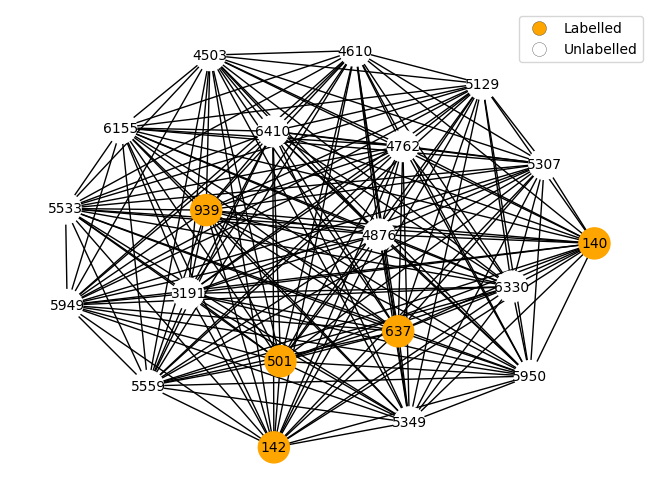

In [501]:
import networkx as nx
import matplotlib.pyplot as plt

X_phase2_all_dummies.reset_index(drop=True, inplace=True)

# Create a new graph
G = nx.Graph()

# This is the node of interest
node_idx = 140 

# Query its nearest neighbors
distances, indices = tree.query([X_phase2_all_dummies.iloc[node_idx,:]], k=20)  # get k-nearest neighbors
indices = indices[0]  # Flatten the array
selected_nodes = indices

G.add_nodes_from(selected_nodes)

# Populate with colors based on label status
node_colors = []
for i in selected_nodes:
    if i < n_labelled:
        node_colors.append('orange')  
    else:
        node_colors.append('white')  

# Add edges to the graph
for i in indices:
    for j in indices:
        if i != j:
            # Use Gaussian similarity as the weight for the edges
            weight = np.exp(-np.linalg.norm(X_phase2_all_dummies.iloc[i,:] - X_phase2_all_dummies.iloc[j,:])**2 / (2 * sigma ** 2))
            G.add_edge(i, j, weight=weight)

pos = nx.spring_layout(G, weight='weight', seed=42)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10)
green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Labelled', markeredgewidth=0.2, markeredgecolor='black')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markeredgecolor='black', markeredgewidth=0.2, markersize=10, label='Unlabelled')
plt.legend(handles=[green_patch, red_patch])
plt.show()


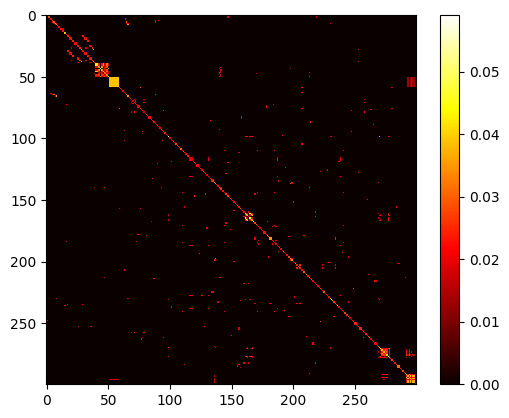

In [500]:
plt.imshow((transition_matrix[70:370, 70:370]).toarray(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


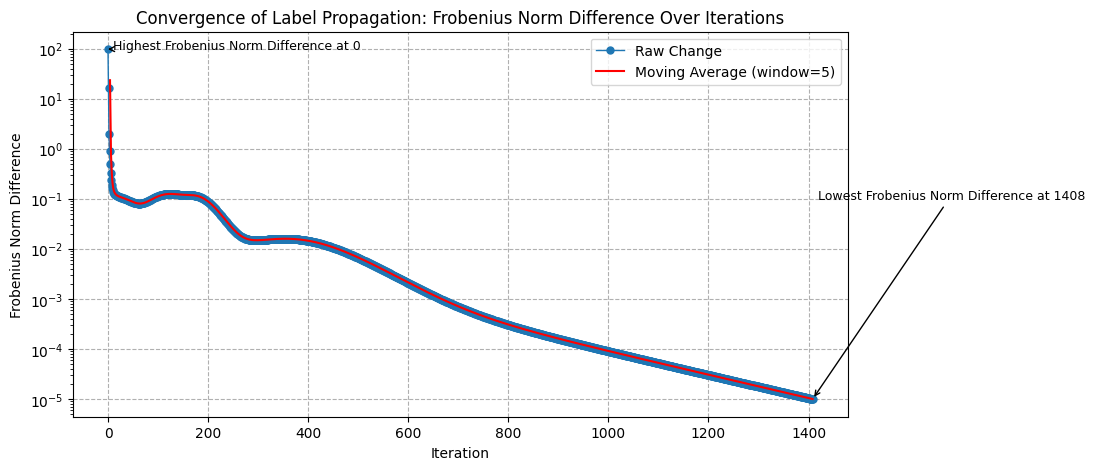

In [499]:
# Mock changes for demonstration. Replace with your actual 'changes' list.
plt.figure(figsize=(10, 5))

# Main plot with markers
plt.plot(changes, marker='o', linestyle='-', linewidth=1, markersize=5, label='Raw Change')

# Add grid
plt.grid(True, linestyle='--')

# Add titles and labels
plt.title('Convergence of Label Propagation: Frobenius Norm Difference Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Frobenius Norm Difference')
plt.gca().set_yscale("log")


# Highlight specific points (like lowest or highest change)
min_change_idx = np.argmin(changes)
max_change_idx = np.argmax(changes)
plt.annotate(f'Lowest Frobenius Norm Difference at {min_change_idx}', xy=(min_change_idx, changes[min_change_idx]), xytext=(min_change_idx+10, changes[min_change_idx]+0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=9)
plt.annotate(f'Highest Frobenius Norm Difference at {max_change_idx}', xy=(max_change_idx, changes[max_change_idx]), xytext=(max_change_idx+10, changes[max_change_idx]+0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=9)

# Optional: Add moving average line
window_size = 5
rolling_mean = np.convolve(changes, np.ones(window_size)/window_size, mode='valid')
plt.plot(np.arange(window_size-1, len(changes)), rolling_mean, 'r', label=f'Moving Average (window={window_size})')

# Add legend
plt.legend()

plt.show()


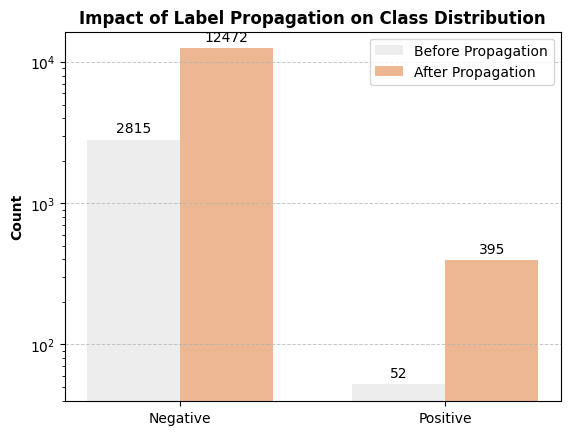

In [512]:
# Dummy data for illustration
labels_before = [y_phase2_labelled.value_counts()['Negative'], y_phase2_labelled.value_counts()['Positive']]
prediction_ofPropagation = pd.Series(['Positive' if label_numeric == 1 else 'Negative' for label_numeric in np.round(Y_next[:,1])])

labels_after = [prediction_ofPropagation.value_counts()['Negative'], prediction_ofPropagation.value_counts()['Positive']]  

# Prepare the plot
x = np.arange(len(labels_before))
width = 0.35

# Create the bar plot
fig, ax = plt.subplots()

light_gray = (0.9, 0.9, 0.9)
rects1 = ax.bar(x - width/2, labels_before, width, alpha=0.7, label='Before Propagation', color=light_gray)
light_orange = (0.9, 0.6, 0.4)
rects2 = ax.bar(x + width/2, labels_after, width, alpha=0.7, label='After Propagation', color=light_orange)

# Add annotations, grid, and labels
ax.set_xticks(x)
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Impact of Label Propagation on Class Distribution', fontweight='bold')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend()
ax.set_yscale("log")


# Annotate the bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


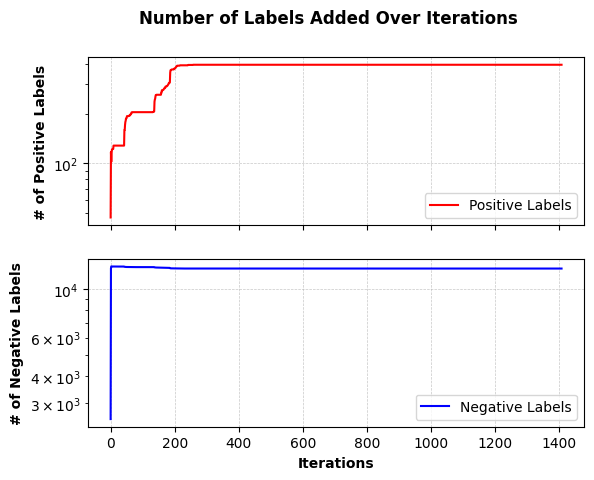

In [498]:
iterations = np.arange(0, iteration + 1)

fig, axs = plt.subplots(2, 1, sharex=True)

# Plot for Positive Labels
axs[0].plot(iterations, count_positive_over_time, label='Positive Labels', color='red')
axs[0].set_ylabel('# of Positive Labels', fontweight='bold')
axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
axs[0].legend()
axs[0].set_yscale("log")


# Plot for Negative Labels
axs[1].plot(iterations, count_negative_over_time, label='Negative Labels', color='blue')
axs[1].set_xlabel('Iterations', fontweight='bold')
axs[1].set_ylabel('# of Negative Labels', fontweight='bold')
axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
axs[1].legend()
axs[1].set_yscale("log")

# Add a title for the whole figure
fig.suptitle('Number of Labels Added Over Iterations', fontweight='bold')

plt.show()
